# 1. Import

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torch
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [139]:
np.random.seed(1234)  
PYTHONHASHSEED = 0

# 2. Loading data

In [140]:
train_df = pd.read_csv('../data/PM_train.txt', sep= " ", header= None)
test_df = pd.read_csv('../data/PM_test.txt', sep= " ", header= None)
truth_df = pd.read_csv('../data/PM_truth.txt', sep= " ", header= None)

In [141]:
train_df.dropna(axis= 1, inplace= True)
test_df.dropna(axis= 1, inplace= True)

In [142]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

In [143]:
truth_df.dropna(axis=1, inplace=True)
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


# 3. Data processing

In [144]:
train_df.sort_values(['id','cycle'], inplace=True)

In [145]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on= 'id', how= 'left')

train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df[['id', 'cycle', 'max', 'RUL']].head()

,id,cycle,max,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [146]:
train_df.drop('max', axis= 1, inplace=True)

In [147]:
test_df.sort_values(['id','cycle'], inplace=True)

In [148]:
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['additional_rul']

truth_df['id'] = truth_df.index + 1

truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

test_df = test_df.merge(truth_df, on='id', how='left')
# test_df.head()
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

test_df[['id', 'cycle', 'RUL']].head()

,id,cycle,RUL
0,1,1,142
1,1,2,141
2,1,3,140
3,1,4,139
4,1,5,138


In [149]:
RUL_THRESHOLD = 50

## Normalize training data

In [150]:
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])

In [151]:
features_train = train_df[cols_normalize]
labels_train = (train_df['RUL'] <= RUL_THRESHOLD).astype(float).values

In [152]:
scaler = preprocessing.MinMaxScaler()
features_train = scaler.fit_transform(features_train)
norm_train_df = pd.DataFrame(features_train,
                            columns= cols_normalize, index= train_df.index)
norm_train_df

,s1,s10,s11,s12,s13,s14,s15,s16,s17,s18,...,s3,s4,s5,s6,s7,s8,s9,setting1,setting2,setting3
0,0.0,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,...,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.459770,0.166667,0.0
1,0.0,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,...,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.609195,0.250000,0.0
2,0.0,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,...,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.252874,0.750000,0.0
3,0.0,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,...,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.540230,0.500000,0.0
4,0.0,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,...,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.390805,0.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,0.0,0.0,0.726190,0.170576,0.558824,0.194344,0.656791,0.0,0.750000,0.0,...,0.587312,0.782917,0.0,1.0,0.254428,0.439394,0.196491,0.477011,0.250000,0.0
20627,0.0,0.0,0.708333,0.211087,0.500000,0.188668,0.727203,0.0,0.583333,0.0,...,0.729453,0.866475,0.0,1.0,0.162641,0.500000,0.194651,0.408046,0.083333,0.0
20628,0.0,0.0,0.738095,0.281450,0.529412,0.212148,0.922278,0.0,0.833333,0.0,...,0.684979,0.775321,0.0,1.0,0.175523,0.515152,0.198196,0.522989,0.500000,0.0
20629,0.0,0.0,0.916667,0.208955,0.514706,0.203065,0.823394,0.0,0.583333,0.0,...,0.746021,0.747468,0.0,1.0,0.133655,0.530303,0.233285,0.436782,0.750000,0.0


# 4. Building LSTM model

In [153]:
features_train = torch.tensor(features_train, dtype=torch.float32)
labels_train = torch.tensor(labels_train, dtype=torch.float32)

In [154]:
train_size = int(0.8 * len(features_train))
test_size = len(features_train) - train_size

features_train, features_valid = features_train[:train_size], features_train[train_size:]
labels_train, labels_valid = labels_train[:train_size], labels_train[train_size:]

In [155]:
# Custom dataset class
class MaintenanceDataset(Dataset):
    def __init__(self, features, labels, seq_length):
        self.features = features
        self.labels = labels
        self.seq_length = seq_length

    def __len__(self):
        return len(self.features) - self.seq_length

    def __getitem__(self, idx):
        return (self.features[idx:idx+self.seq_length], self.labels[idx+self.seq_length])

# Hyperparameters
SEQ_LENGTH = 30  # Sequence length for LSTM

# Create dataset and dataloader
train_dataset = MaintenanceDataset(features_train, labels_train, SEQ_LENGTH)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = MaintenanceDataset(features_valid, labels_valid, SEQ_LENGTH)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [156]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()  # Add sigmoid activation for binary classification

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(self.dropout(out[:, -1, :]))  # Take the output of the last time step and apply dropout
        out = self.sigmoid(out)  # Apply sigmoid activation for binary classification
        return out

# Hyperparameters
INPUT_DIM = features_train.shape[1]
HIDDEN_DIM = 128
OUTPUT_DIM = 1
NUM_LAYERS = 2
DROPOUT_PROB = 0.5

# Instantiate the model
model = LSTMModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT_PROB)

In [157]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [158]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMModel(
  (lstm): LSTM(24, 128, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)

## 4.1. Training loop

In [159]:
NUM_EPOCHS = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [160]:
for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    epoch_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0
    
    for features, labels in train_dataloader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        total_train_samples += labels.size(0)
        correct_train_predictions += ((outputs > 0.5).float() == labels.view(-1, 1)).sum().item()
    
    average_train_loss = epoch_train_loss / len(train_dataloader)
    train_accuracy = correct_train_predictions / total_train_samples
    
    train_losses.append(average_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for features, labels in valid_dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels.view(-1, 1))
            
            epoch_val_loss += loss.item()
            total_val_samples += labels.size(0)
            correct_val_predictions += ((outputs > 0.5).float() == labels.view(-1, 1)).sum().item()
    
    average_val_loss = epoch_val_loss / len(valid_dataloader)
    val_accuracy = correct_val_predictions / total_val_samples
    
    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {average_train_loss:.4f},Val Loss: {average_val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch [1/100], Train Loss: 0.2389,Val Loss: 0.1932, Train Acc: 0.9046, Val Acc: 0.9212
Epoch [2/100], Train Loss: 0.1642,Val Loss: 0.1429, Train Acc: 0.9363, Val Acc: 0.9434
Epoch [3/100], Train Loss: 0.1389,Val Loss: 0.1581, Train Acc: 0.9449, Val Acc: 0.9395
Epoch [4/100], Train Loss: 0.1318,Val Loss: 0.1278, Train Acc: 0.9471, Val Acc: 0.9461
Epoch [5/100], Train Loss: 0.1263,Val Loss: 0.1144, Train Acc: 0.9483, Val Acc: 0.9561
Epoch [6/100], Train Loss: 0.1273,Val Loss: 0.1240, Train Acc: 0.9469, Val Acc: 0.9558
Epoch [7/100], Train Loss: 0.1191,Val Loss: 0.1103, Train Acc: 0.9511, Val Acc: 0.9541
Epoch [8/100], Train Loss: 0.1136,Val Loss: 0.1134, Train Acc: 0.9534, Val Acc: 0.9570
Epoch [9/100], Train Loss: 0.1309,Val Loss: 0.1268, Train Acc: 0.9484, Val Acc: 0.9519
Epoch [10/100], Train Loss: 0.1125,Val Loss: 0.1224, Train Acc: 0.9514, Val Acc: 0.9470
Epoch [11/100], Train Loss: 0.1092,Val Loss: 0.1395, Train Acc: 0.9543, Val Acc: 0.9475
Epoch [12/100], Train Loss: 0.1028,Val Lo

## 4.1. Visualization

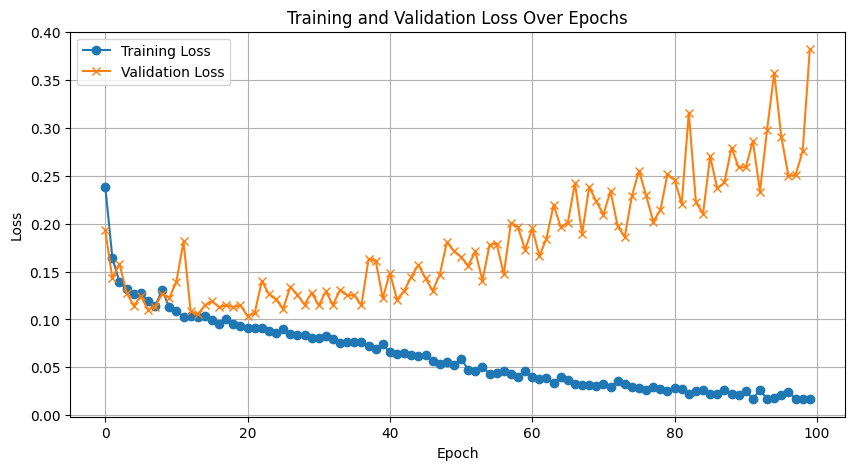

In [161]:
plt.figure(figsize=(10, 5))
plt.plot(range(NUM_EPOCHS), train_losses, marker='o', label='Training Loss')
plt.plot(range(NUM_EPOCHS), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

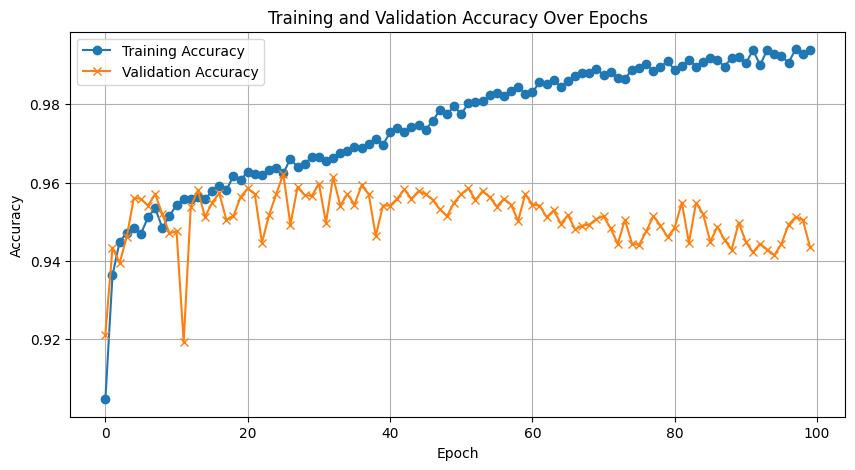

In [162]:
plt.figure(figsize=(10, 5))
plt.plot(range(NUM_EPOCHS), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(NUM_EPOCHS), val_accuracies, marker='x', label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# 5. Testing

## Normalize testing data

In [163]:
features_test = test_df[cols_normalize]
labels_test = (test_df['RUL'] <= RUL_THRESHOLD).astype(float).values

In [164]:
features_test = scaler.fit_transform(features_test)
norm_test_df = pd.DataFrame(features_test,
                            columns= cols_normalize, index= test_df.index)
norm_test_df

,s1,s10,s11,s12,s13,s14,s15,s16,s17,s18,...,s3,s4,s5,s6,s7,s8,s9,setting1,setting2,setting3
0,0.0,0.0,0.273973,0.534247,0.325581,0.152259,0.347076,0.0,0.375,0.0,...,0.421968,0.282214,0.0,1.0,0.608871,0.365854,0.196475,0.65625,0.692308,0.0
1,0.0,0.0,0.479452,0.634703,0.395349,0.277907,0.227709,0.0,0.500,0.0,...,0.504025,0.225240,0.0,1.0,0.800403,0.292683,0.229042,0.34375,0.230769,0.0
2,0.0,0.0,0.479452,0.591324,0.325581,0.192892,0.533557,0.0,0.500,0.0,...,0.464814,0.346130,0.0,1.0,0.651210,0.390244,0.248506,0.53125,0.538462,0.0
3,0.0,0.0,0.328767,0.456621,0.372093,0.217896,0.282359,0.0,0.250,0.0,...,0.391587,0.449867,0.0,1.0,0.643145,0.341463,0.159080,0.77500,0.461538,0.0
4,0.0,0.0,0.349315,0.632420,0.325581,0.187891,0.337009,0.0,0.125,0.0,...,0.471306,0.357974,0.0,1.0,0.661290,0.292683,0.153410,0.60000,0.461538,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,0.0,0.0,0.609589,0.299087,0.255814,0.935703,0.664909,0.0,0.625,0.0,...,0.789665,0.641209,0.0,1.0,0.510081,0.317073,0.902989,0.81875,0.461538,0.0
13092,0.0,0.0,0.547945,0.381279,0.465116,0.914003,0.567593,0.0,0.750,0.0,...,0.692028,0.769042,0.0,1.0,0.471774,0.390244,0.890038,0.44375,0.384615,0.0
13093,0.0,0.0,0.527397,0.410959,0.348837,0.971066,0.594919,0.0,0.750,0.0,...,0.626071,0.458036,0.0,1.0,0.435484,0.536585,0.937011,0.47500,0.230769,0.0
13094,0.0,0.0,0.554795,0.445205,0.441860,1.000000,0.662991,0.0,0.750,0.0,...,0.673851,0.714111,0.0,1.0,0.502016,0.439024,0.952644,0.27500,0.538462,0.0


In [165]:
features_test = torch.tensor(features_test, dtype=torch.float32)
labels_test = torch.tensor(labels_test, dtype=torch.float32)

In [166]:
test_dataset = MaintenanceDataset(features_test, labels_test, SEQ_LENGTH)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [167]:
model.eval()
test_predictions = []
test_true_values = []
with torch.no_grad():
    for features, labels in test_dataloader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        test_predictions.append(outputs.item())
        test_true_values.append(labels.item())

# Calculate evaluation metrics (e.g., accuracy) for test data
test_accuracy = accuracy_score(test_true_values, [1 if pred > 0.5 else 0 for pred in test_predictions])
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 77.72%


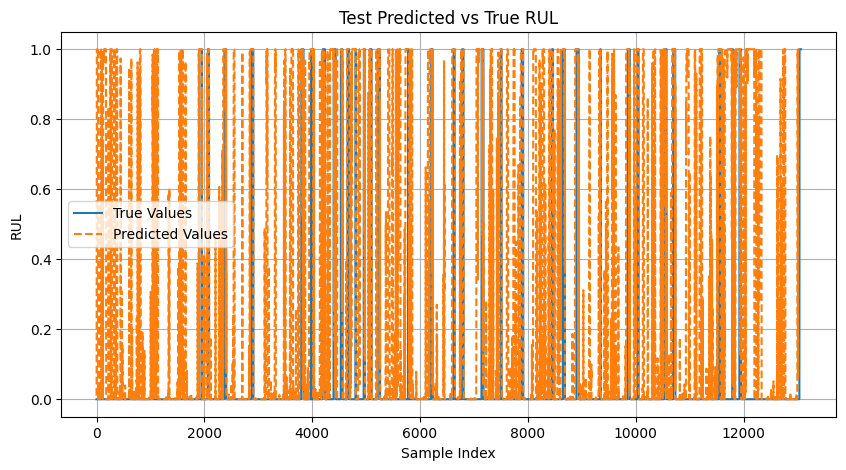

In [175]:
plt.figure(figsize=(10, 5))
plt.plot(test_true_values, label='True Values')
plt.plot(test_predictions, label='Predicted Values', linestyle='--')
plt.title('Test Predicted vs True RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.grid()
plt.show()